In [40]:
# Install necessary packages
! pip install transformers evaluate scikit-learn seaborn imbalanced-learn torch

import numpy as np
import pandas as pd

from datasets import load_dataset
from datasets import ClassLabel, Value

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import AdamW

from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import get_scheduler

import evaluate
import json
import pandas as pd
import seaborn as sns
from nltk import ngrams
from collections import Counter
import numpy as np

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
import json
import warnings
warnings.filterwarnings('ignore')

^C


Defaulting to user installation because normal site-packages is not writeable


In [ ]:
# Define file paths for training and validation datasets
root_path = "C:/Users/wrksy/OneDrive/Desktop/Projects/7120CW2_code/data/"
train_file_path = root_path + 'train.jsonl'
val_file_path = root_path + 'validation.jsonl'

In [ ]:
# Load and preprocess data
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        sentences = [json.loads(sentence.rstrip()) for sentence in f.readlines()]
        filtered_sentences = [
            {
                _key: _value 
                for _key, _value in _sentence.items() 
                if _key in ['uuid', 'postText', 'targetTitle', 'targetParagraphs', 'spoiler', 'spoilerPositions', 'tags']
            } 
            for _sentence in sentences
        ]
    return filtered_sentences

train_data = load_data(train_file_path)
val_data = load_data(val_file_path)

In [ ]:
# Reformat spoiler positions
def reformat_spoiler_positions(data):
    reformatted_data = []
    ignore_idx = []

    for _idx, _sentence in enumerate(data):
        spoiler_positions = _sentence['spoilerPositions']
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['targetParagraphs']
        all_target_paragraphs = [target_title] + target_paragraphs

        refactored_spoiler_positions = {}
        for _spoiler_passage_positions in spoiler_positions:
            if len(_spoiler_passage_positions) != 2:
                print('Ignoring idx: {}'.format(_idx))
                ignore_idx.append(_idx)
                break

            _start_pos = _spoiler_passage_positions[0][1]
            _start_pos_passage = _spoiler_passage_positions[0][0]
            _end_pos = _spoiler_passage_positions[1][1]
            _end_pos_passage = _spoiler_passage_positions[1][0]

            if _start_pos_passage != _end_pos_passage:
                _refactored_spoiler_positions = {}

                for _passage_idx in range(_start_pos_passage, _end_pos_passage):
                    if _passage_idx == _start_pos_passage:
                        _start = _start_pos - len(' '.join(target_paragraphs[:_passage_idx])) - 1
                        _refactored_spoiler_positions[_passage_idx + 1] = [
                            (_start if _start == 0 else _start - 1, None)]
                    elif _passage_idx == _end_pos_passage:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, _end_pos - 1 - len(' '.join(target_paragraphs[:_passage_idx])))]
                    else:
                        _refactored_spoiler_positions[_passage_idx + 1] = [(None, None)]

                for _key, _value in _refactored_spoiler_positions.items():
                    if _key not in refactored_spoiler_positions:
                        refactored_spoiler_positions[_key] = _value 
                    else:
                        refactored_spoiler_positions[_key].extend(_value)
            else:
                if _start_pos_passage + 1 not in refactored_spoiler_positions:
                    refactored_spoiler_positions[_start_pos_passage + 1] = [(_start_pos, _end_pos)]
                else:
                    refactored_spoiler_positions[_start_pos_passage + 1].append((_start_pos, _end_pos))

        reformatted_data.append({
            **_sentence,
            'allTargetParagraphs': all_target_paragraphs,
            'refactoredSpoilerPositions': refactored_spoiler_positions
        })
        
    return reformatted_data, ignore_idx

train_data_reformatted, _ = reformat_spoiler_positions(data=train_data)
val_data_reformatted, _ = reformat_spoiler_positions(data=val_data)

Ignoring idx: 546


In [ ]:
# Remove bad matches data
def remove_bad_matches_data(data):
    exact_match_bad_annotations = []
    exact_match_bad_annotations_ids = []
    not_found_exact_matches = {}

    clean_data = []

    for _idx, _sentence in enumerate(data):
        for _key in _sentence['refactoredSpoilerPositions'].keys():
            for _value_idx in range(len(_sentence['refactoredSpoilerPositions'][_key])):
        
                _start_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][0]
                _end_pos = _sentence['refactoredSpoilerPositions'][_key][_value_idx][1]

                if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] not in _sentence['spoiler'] and not any(True for _spoiler in _sentence['spoiler'] if _sentence['allTargetParagraphs'][_key][_start_pos: _end_pos] in _spoiler):
                    exact_match_bad_annotations.append(_sentence)
                    exact_match_bad_annotations_ids.append(_idx)
                    if _idx not in not_found_exact_matches:
                        not_found_exact_matches[_idx] = [_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos]]
                    else:
                        not_found_exact_matches[_idx].append(_sentence['allTargetParagraphs'][_key][_start_pos: _end_pos])
                else:
                    clean_data.append(_sentence)
  
    return clean_data, exact_match_bad_annotations_ids, not_found_exact_matches

clean_train_data, _, not_found_spoilers_train = remove_bad_matches_data(data=train_data_reformatted)
clean_val_data, _, not_found_spoilers_val = remove_bad_matches_data(data=val_data_reformatted)


In [ ]:
# Flatten nested data
def flatten_data(data, change_multi=True):
    flattened_data = []
    for _sentence in data:
        uuid = _sentence['uuid']
        post = ' '.join(_sentence['postText'])
        target_title = _sentence['targetTitle']
        target_paragraphs = _sentence['allTargetParagraphs']
        spoiler_positions = _sentence['refactoredSpoilerPositions']
        spoiler_type = _sentence['tags']

        for _idx, _target_paragraph in enumerate(target_paragraphs):
            _spoiler_pos = spoiler_positions.get(_idx, None)

            if not change_multi and spoiler_type[0] != 'multi':
                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': spoiler_type[0] if _spoiler_pos else None,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)
            else:
                _spoiler_type = None
                if _spoiler_pos:
                    if spoiler_type[0] != 'multi':
                        _spoiler_type = spoiler_type[0]
                    else:
                        _spoiler_texts = ([_target_paragraph[__spoiler_pos[0]: __spoiler_pos[1]] for __spoiler_pos in _spoiler_pos])
                        _max_length = max([len(_x.split(' ')) for _x in _spoiler_texts])
                        if _max_length <=5:
                            _spoiler_type = 'phrase'
                        else:
                            _spoiler_type = 'passage'

                _data = {
                    'uuid': uuid,
                    'targetParagraphId': _idx,
                    'postText': post,
                    'targetTitle': target_title,
                    'targetParagraph': _target_paragraph,
                    'spoilerType': _spoiler_type,
                    'spoilerPos': _spoiler_pos if _spoiler_pos else None
                }
                flattened_data.append(_data)

    return flattened_data

flattened_train_data = flatten_data(data=clean_train_data, change_multi=True)
flattened_val_data = flatten_data(data=clean_val_data, change_multi=True)


<Axes: xlabel='Data', ylabel='Count'>

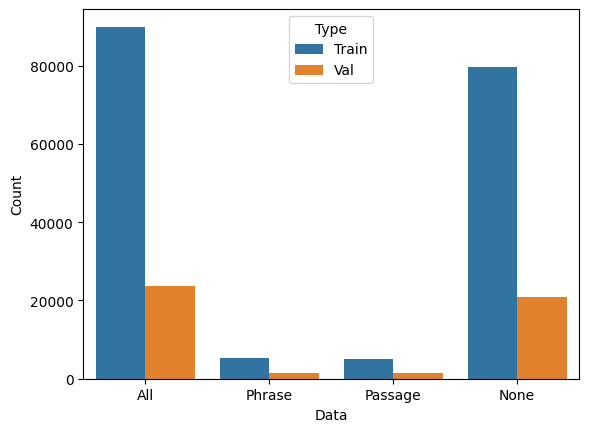

In [ ]:
# flattened data distribution
distribution_df = pd.DataFrame(columns=["Data", "Type", "Count"], data={
    "Data":['All', 'All', 'Phrase', 'Phrase', 'Passage', 'Passage', 'None', 'None'],
    "Count": [len(flattened_train_data),
              len(flattened_val_data),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'phrase']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == 'passage']),
              len([_x for _x in flattened_train_data if _x['spoilerType'] == None]),
              len([_x for _x in flattened_val_data if _x['spoilerType'] == None])],
    "Type": ['Train', 'Val', 'Train', 'Val', 'Train', 'Val', 'Train', 'Val']
})
sns.barplot(distribution_df, x="Data" , y="Count", hue="Type")


In [ ]:
# This function takes a text string and an integer n, splits the text into tokens, 
# and returns a list of n-grams (tuples of n consecutive tokens).
def generate_ngrams(text, n):
    tokens = text.split()
    return list(ngrams(tokens, n))

# Function to prepare n-grams data from flattened data
# This function iterates through the flattened data, combines the post text and target paragraph,
# generates n-grams, and appends them along with the corresponding uuid, target paragraph ID, and spoiler type to a list.
def prepare_ngrams_data(flattened_data, n=2):
    ngrams_data = []
    for _x in flattened_data:
        text = _x['postText'] + ' ' + _x['targetParagraph']
        ngrams = generate_ngrams(text, n)
        ngrams_data.append({
            'uuid': _x['uuid'],
            'targetParagraphId': _x['targetParagraphId'],
            'ngrams': ngrams,
            'spoilerType': _x['spoilerType']
        })
    return ngrams_data

# Generate bi-grams and tri-grams for training and validation data
# Using the prepare_ngrams_data function to create lists of bi-grams and tri-grams for both training and validation datasets.
bigrams_train_data = prepare_ngrams_data(flattened_train_data, n=2)
trigrams_train_data = prepare_ngrams_data(flattened_train_data, n=3)
bigrams_val_data = prepare_ngrams_data(flattened_val_data, n=2)
trigrams_val_data = prepare_ngrams_data(flattened_val_data, n=3)

# Displaying the first few entries of the bi-grams and tri-grams
# Printing out examples of the generated bi-grams and tri-grams for both training and validation data to verify the output.
print("Bigrams Training Data Example: ", bigrams_train_data[:2])
print("-" * 50)
print("Trigrams Training Data Example: ", trigrams_train_data[:2])
print("-" * 50)
print("Bigrams Validation Data Example: ", bigrams_val_data[:2])
print("-" * 50)
print("Trigrams Validation Data Example: ", trigrams_val_data[:2])



Bigrams Training Data Example:  [{'uuid': '0af11f6b-c889-4520-9372-66ba25cb7657', 'targetParagraphId': 0, 'ngrams': [('Wes', 'Welker'), ('Welker', 'Wanted'), ('Wanted', 'Dinner'), ('Dinner', 'With'), ('With', 'Tom'), ('Tom', 'Brady,'), ('Brady,', 'But'), ('But', 'Patriots'), ('Patriots', 'QB'), ('QB', 'Had'), ('Had', 'Better'), ('Better', 'Idea'), ('Idea', 'Wes'), ('Wes', 'Welker'), ('Welker', 'Wanted'), ('Wanted', 'Dinner'), ('Dinner', 'With'), ('With', 'Tom'), ('Tom', 'Brady,'), ('Brady,', 'But'), ('But', 'Patriots'), ('Patriots', 'QB'), ('QB', 'Had'), ('Had', 'A'), ('A', 'Better'), ('Better', 'Idea')], 'spoilerType': None}, {'uuid': '0af11f6b-c889-4520-9372-66ba25cb7657', 'targetParagraphId': 1, 'ngrams': [('Wes', 'Welker'), ('Welker', 'Wanted'), ('Wanted', 'Dinner'), ('Dinner', 'With'), ('With', 'Tom'), ('Tom', 'Brady,'), ('Brady,', 'But'), ('But', 'Patriots'), ('Patriots', 'QB'), ('QB', 'Had'), ('Had', 'Better'), ('Better', 'Idea'), ('Idea', 'It’ll'), ('It’ll', 'be'), ('be', 'just

In [ ]:
# Create DataFrame
df_train = pd.DataFrame(flattened_train_data)
df_val = pd.DataFrame(flattened_val_data)

In [ ]:
# Create feature and label datasets for classification
df_classification_train = df_train[df_train['spoilerType'].notna()]
df_classification_val = df_val[df_val['spoilerType'].notna()]

In [ ]:
# Encode the labels
label_encoder = preprocessing.LabelEncoder()
df_classification_train['labels'] = label_encoder.fit_transform(df_classification_train['spoilerType'])
df_classification_val['labels'] = label_encoder.transform(df_classification_val['spoilerType'])

# Save the class names for future use
class_names = label_encoder.classes_

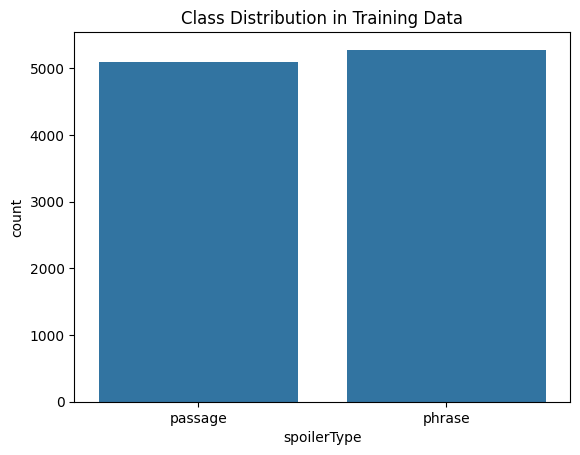

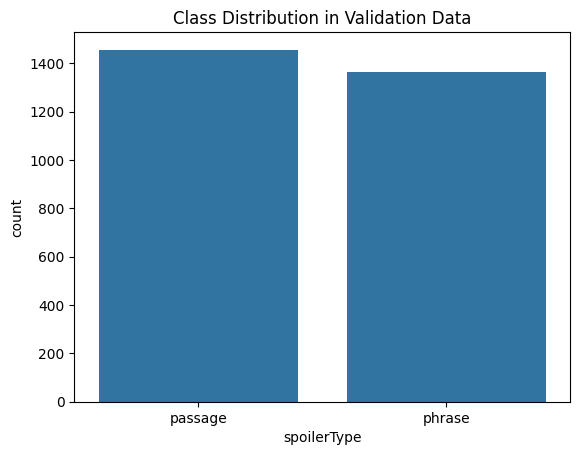

In [ ]:
sns.countplot(x='spoilerType', data=df_classification_train)
plt.title('Class Distribution in Training Data')
plt.show()

sns.countplot(x='spoilerType', data=df_classification_val)
plt.title('Class Distribution in Validation Data')
plt.show()


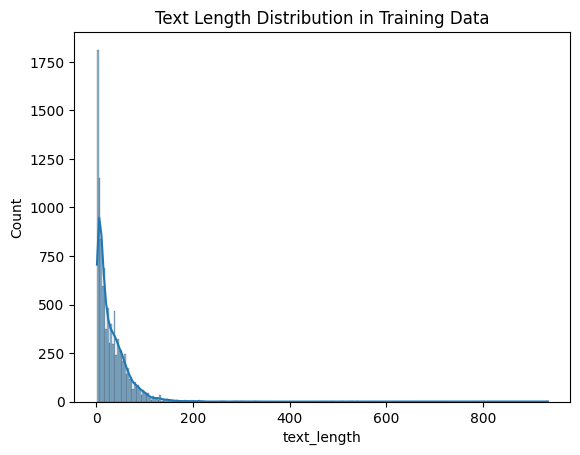

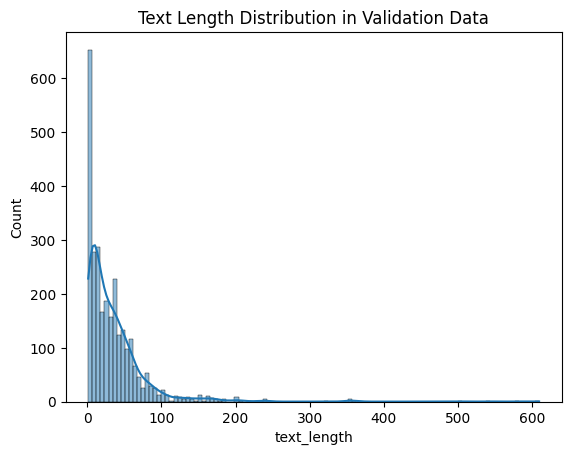

In [ ]:
df_classification_train['text_length'] = df_classification_train['targetParagraph'].apply(lambda x: len(x.split()))
sns.histplot(df_classification_train['text_length'], kde=True)
plt.title('Text Length Distribution in Training Data')
plt.show()

df_classification_val['text_length'] = df_classification_val['targetParagraph'].apply(lambda x: len(x.split()))
sns.histplot(df_classification_val['text_length'], kde=True)
plt.title('Text Length Distribution in Validation Data')
plt.show()


In [ ]:
# Define custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# Text augmentation
import random
from nltk.corpus import wordnet
import nltk

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def synonym_replacement(words, n):
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  # only replace up to n words
            break
    return new_words

def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym)
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

def augment_text(sentence, n_aug=1):
    words = sentence.split()
    augmented_sentences = []
    num_words = len(words)
    n_sr = max(1, int(0.1*num_words))
    for _ in range(n_aug):
        a_words = synonym_replacement(words, n_sr)
        augmented_sentences.append(' '.join(a_words))
    return augmented_sentences

def augment_dataset(df, n_aug=1):
    augmented_data = []
    for index, row in df.iterrows():
        augmented_texts = augment_text(row['postText'], n_aug)
        for aug_text in augmented_texts:
            new_row = row.copy()
            new_row['postText'] = aug_text
            augmented_data.append(new_row)
    return pd.DataFrame(augmented_data)

# Data augmentation
augmented_train_df = augment_dataset(train_data_df, n_aug=1)

# Combine original and augmented data
train_data_df = pd.concat([train_data_df, augmented_train_df]).reset_index(drop=True)

# Encode labels
label_encoder = preprocessing.LabelEncoder()
train_data_df['spoilerType'] = label_encoder.fit_transform(train_data_df['spoilerType'])
val_data_df['spoilerType'] = label_encoder.transform(val_data_df['spoilerType'])


In [ ]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 512

In [ ]:
# Create datasets
train_dataset = TextDataset(df_classification_train['targetParagraph'].tolist(), df_classification_train['labels'].tolist(), tokenizer, max_len)
val_dataset = TextDataset(df_classification_val['targetParagraph'].tolist(), df_classification_val['labels'].tolist(), tokenizer, max_len)


In [ ]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [ ]:
# Define CNN Model
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = nn.Conv2d(1, 100, (3, embed_dim))
        self.conv2 = nn.Conv2d(1, 100, (4, embed_dim))
        self.conv3 = nn.Conv2d(1, 100, (5, embed_dim))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(300, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x1 = torch.relu(self.conv1(x)).squeeze(3)
        x1 = torch.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = torch.relu(self.conv2(x)).squeeze(3)
        x2 = torch.max_pool1d(x2, x2.size(2)).squeeze(2)
        x3 = torch.relu(self.conv3(x)).squeeze(3)
        x3 = torch.max_pool1d(x3, x3.size(2)).squeeze(2)
        x = torch.cat((x1, x2, x3), 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [ ]:
# Define RNN Model
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        return x


In [ ]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x


In [44]:
# Define training and evaluation functions
def train_model(model, train_loader, val_loader, device, epochs=20):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0

        for data in train_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions.double() / len(train_loader.dataset)

        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}")

        eval_model(model, val_loader, device)

def eval_model(model, val_loader, device):
    model = model.eval()
    total_loss = 0
    correct_predictions = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data in val_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels = data['label'].to(device)

            outputs = model(input_ids)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions.double() / len(val_loader.dataset)

    print(f"Validation Loss: {avg_loss:.4f}, Validation Accuracy: {accuracy:.4f}")


In [45]:
# Train and evaluate models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [46]:
# CNN Model
cnn_model = CNN(vocab_size=len(tokenizer), embed_dim=256, num_classes=3)
print("Training CNN Model")
train_model(cnn_model, train_loader, val_loader, device)


Training CNN Model
Epoch 1/20
Train Loss: 0.7863, Train Accuracy: 0.5790
Validation Loss: 0.6105, Validation Accuracy: 0.6423
Epoch 2/20
Train Loss: 0.6533, Train Accuracy: 0.6438
Validation Loss: 0.5966, Validation Accuracy: 0.6380
Epoch 3/20
Train Loss: 0.5979, Train Accuracy: 0.6791
Validation Loss: 0.5873, Validation Accuracy: 0.6476
Epoch 4/20
Train Loss: 0.5563, Train Accuracy: 0.7084
Validation Loss: 0.5811, Validation Accuracy: 0.6583
Epoch 5/20
Train Loss: 0.5204, Train Accuracy: 0.7393
Validation Loss: 0.5802, Validation Accuracy: 0.6480
Epoch 6/20
Train Loss: 0.5027, Train Accuracy: 0.7515
Validation Loss: 0.5803, Validation Accuracy: 0.6405
Epoch 7/20
Train Loss: 0.4620, Train Accuracy: 0.7790
Validation Loss: 0.5758, Validation Accuracy: 0.6451
Epoch 8/20
Train Loss: 0.4348, Train Accuracy: 0.8023
Validation Loss: 0.5723, Validation Accuracy: 0.6529
Epoch 9/20
Train Loss: 0.4132, Train Accuracy: 0.8213
Validation Loss: 0.5734, Validation Accuracy: 0.6462
Epoch 10/20
Train 

In [47]:
# RNN Model
rnn_model = RNN(vocab_size=len(tokenizer), embed_dim=128, hidden_dim=256, num_classes=3)
print("Training RNN Model")
train_model(rnn_model, train_loader, val_loader, device)

Training RNN Model
Epoch 1/20
Train Loss: 0.7173, Train Accuracy: 0.4988
Validation Loss: 0.6974, Validation Accuracy: 0.4833
Epoch 2/20
Train Loss: 0.6965, Train Accuracy: 0.4932
Validation Loss: 0.6971, Validation Accuracy: 0.4833
Epoch 3/20
Train Loss: 0.6954, Train Accuracy: 0.5026
Validation Loss: 0.6941, Validation Accuracy: 0.5167
Epoch 4/20
Train Loss: 0.6948, Train Accuracy: 0.5048
Validation Loss: 0.6934, Validation Accuracy: 0.5167
Epoch 5/20
Train Loss: 0.6941, Train Accuracy: 0.5042
Validation Loss: 0.6961, Validation Accuracy: 0.4833
Epoch 6/20
Train Loss: 0.6947, Train Accuracy: 0.4984
Validation Loss: 0.6932, Validation Accuracy: 0.5167
Epoch 7/20
Train Loss: 0.6942, Train Accuracy: 0.4993
Validation Loss: 0.6955, Validation Accuracy: 0.4833
Epoch 8/20
Train Loss: 0.6941, Train Accuracy: 0.5081
Validation Loss: 0.6930, Validation Accuracy: 0.5167
Epoch 9/20
Train Loss: 0.6943, Train Accuracy: 0.4959
Validation Loss: 0.6960, Validation Accuracy: 0.4833
Epoch 10/20
Train 

In [48]:
# LSTM Model
lstm_model = LSTM(vocab_size=len(tokenizer), embed_dim=128, hidden_dim=256, num_classes=3)
print("Training LSTM Model")
train_model(lstm_model, train_loader, val_loader, device)

Training LSTM Model
Epoch 1/20
Train Loss: 0.7489, Train Accuracy: 0.4864
Validation Loss: 0.6971, Validation Accuracy: 0.5170
Epoch 2/20
Train Loss: 0.6965, Train Accuracy: 0.5022
Validation Loss: 0.6968, Validation Accuracy: 0.4837
Epoch 3/20
Train Loss: 0.6953, Train Accuracy: 0.5050
Validation Loss: 0.6963, Validation Accuracy: 0.4837
Epoch 4/20
Train Loss: 0.6947, Train Accuracy: 0.5004
Validation Loss: 0.6970, Validation Accuracy: 0.4837
Epoch 5/20
Train Loss: 0.6945, Train Accuracy: 0.5068
Validation Loss: 0.6935, Validation Accuracy: 0.5170
Epoch 6/20
Train Loss: 0.6943, Train Accuracy: 0.5052
Validation Loss: 0.6975, Validation Accuracy: 0.4837
Epoch 7/20
Train Loss: 0.6940, Train Accuracy: 0.4997
Validation Loss: 0.6939, Validation Accuracy: 0.4837
Epoch 8/20
Train Loss: 0.6941, Train Accuracy: 0.5033
Validation Loss: 0.6956, Validation Accuracy: 0.4837
Epoch 9/20
Train Loss: 0.6940, Train Accuracy: 0.4993
Validation Loss: 0.6936, Validation Accuracy: 0.4833
Epoch 10/20
Train

In [49]:
# Evaluate models and print classification reports
def evaluate_and_report(model, val_loader, device, label_encoder):
    model = model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for data in val_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels_batch = data['label'].to(device)

            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds)
            labels.extend(labels_batch)

    predictions = torch.stack(predictions).cpu()
    labels = torch.stack(labels).cpu()

    print(classification_report(labels, predictions, target_names=label_encoder.classes_))


CNN Evaluation
{
    "passage": {
        "precision": 0.6671149966375253,
        "recall": 0.6813186813186813,
        "f1-score": 0.6741420319401971,
        "support": 1456.0
    },
    "phrase": {
        "precision": 0.6513899323816679,
        "recall": 0.6365638766519823,
        "f1-score": 0.6438915707389529,
        "support": 1362.0
    },
    "accuracy": 0.6596877217885024,
    "macro avg": {
        "precision": 0.6592524645095965,
        "recall": 0.6589412789853318,
        "f1-score": 0.659016801339575,
        "support": 2818.0
    },
    "weighted avg": {
        "precision": 0.659514734921245,
        "recall": 0.6596877217885024,
        "f1-score": 0.6595213335171685,
        "support": 2818.0
    }
}


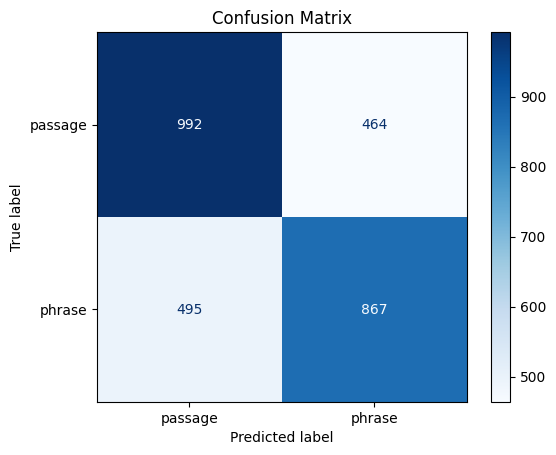

RNN Evaluation
{
    "passage": {
        "precision": 0.5,
        "recall": 0.0013736263736263737,
        "f1-score": 0.0027397260273972603,
        "support": 1456.0
    },
    "phrase": {
        "precision": 0.48329779673063256,
        "recall": 0.9985315712187959,
        "f1-score": 0.6513409961685823,
        "support": 1362.0
    },
    "accuracy": 0.48332150461320084,
    "macro avg": {
        "precision": 0.4916488983653163,
        "recall": 0.4999525987962111,
        "f1-score": 0.3270403610979898,
        "support": 2818.0
    },
    "weighted avg": {
        "precision": 0.49192746598549375,
        "recall": 0.48332150461320084,
        "f1-score": 0.31622266780606795,
        "support": 2818.0
    }
}


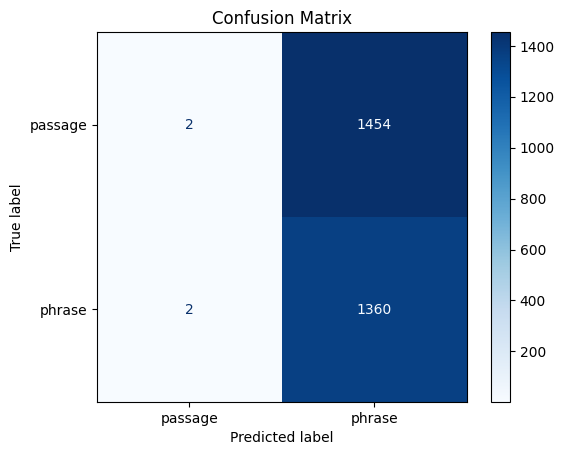

LSTM Evaluation
{
    "passage": {
        "precision": 0.5,
        "recall": 0.0013736263736263737,
        "f1-score": 0.0027397260273972603,
        "support": 1456.0
    },
    "phrase": {
        "precision": 0.48329779673063256,
        "recall": 0.9985315712187959,
        "f1-score": 0.6513409961685823,
        "support": 1362.0
    },
    "accuracy": 0.48332150461320084,
    "macro avg": {
        "precision": 0.4916488983653163,
        "recall": 0.4999525987962111,
        "f1-score": 0.3270403610979898,
        "support": 2818.0
    },
    "weighted avg": {
        "precision": 0.49192746598549375,
        "recall": 0.48332150461320084,
        "f1-score": 0.31622266780606795,
        "support": 2818.0
    }
}


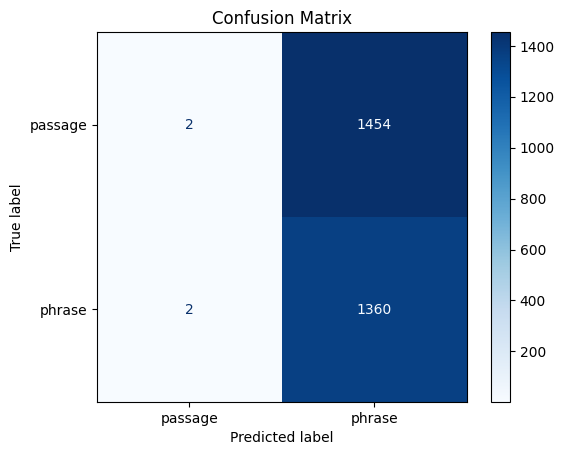


PRECISION:

Label: passage
CNN - passage: 0.6671
RNN - passage: 0.5000
LSTM - passage: 0.5000

Label: phrase
CNN - phrase: 0.6514
RNN - phrase: 0.4833
LSTM - phrase: 0.4833

RECALL:

Label: passage
CNN - passage: 0.6813
RNN - passage: 0.0014
LSTM - passage: 0.0014

Label: phrase
CNN - phrase: 0.6366
RNN - phrase: 0.9985
LSTM - phrase: 0.9985

F1-SCORE:

Label: passage
CNN - passage: 0.6741
RNN - passage: 0.0027
LSTM - passage: 0.0027

Label: phrase
CNN - phrase: 0.6439
RNN - phrase: 0.6513
LSTM - phrase: 0.6513

ACCURACY:
CNN: 0.6597
RNN: 0.4833
LSTM: 0.4833


In [50]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
import matplotlib.pyplot as plt
import json

# Function to evaluate the model and collect predictions and labels
def evaluate_and_report(model, val_loader, device, label_encoder):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for data in val_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            labels_batch = data['label'].to(device)

            outputs = model(input_ids)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            labels.extend(labels_batch.cpu().numpy())

    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, predictions)
    
    # Generate classification report
    report = classification_report(labels, predictions, target_names=label_encoder.classes_, output_dict=True)
    report['accuracy'] = accuracy
    
    # Print classification report
    print(json.dumps(report, indent=4))
    
    # Generate confusion matrix
    cm = confusion_matrix(labels, predictions, labels=range(len(label_encoder.classes_)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return accuracy, report

# Evaluate CNN
print("CNN Evaluation")
cnn_accuracy, cnn_report = evaluate_and_report(cnn_model, val_loader, device, label_encoder)

# Evaluate RNN
print("RNN Evaluation")
rnn_accuracy, rnn_report = evaluate_and_report(rnn_model, val_loader, device, label_encoder)

# Evaluate LSTM
print("LSTM Evaluation")
lstm_accuracy, lstm_report = evaluate_and_report(lstm_model, val_loader, device, label_encoder)

# Compare Model Performance
def compare_models(cnn_report, rnn_report, lstm_report):
    metrics = ['precision', 'recall', 'f1-score', 'accuracy']
    models = ['CNN', 'RNN', 'LSTM']
    reports = [cnn_report, rnn_report, lstm_report]

    for metric in metrics:
        print(f"\n{metric.upper()}:")
        if metric == 'accuracy':
            for model, report in zip(models, reports):
                print(f"{model}: {report['accuracy']:.4f}")
        else:
            for label in label_encoder.classes_:
                print(f"\nLabel: {label}")
                for model, report in zip(models, reports):
                    if label in report:
                        print(f"{model} - {label}: {report[label][metric]:.4f}")

compare_models(cnn_report, rnn_report, lstm_report)
